In [1]:
import argparse
import math
import random
import shutil
import sys
import os
from collections import defaultdict
from typing import List
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from UVG1 import UVG
from matplotlib import pyplot as plt
import torch.nn.functional as F
import matplotlib.patches as patches
import glob
from ssf_model import ScaleSpaceFlow
#from hific.src.model import Model

def load_ssf_model(model, pre_path):
    model.motion_encoder.load_state_dict(torch.load(pre_path+'/m_enc.pth'))
    model.motion_decoder.load_state_dict(torch.load(pre_path+'/m_dec.pth'))
    model.P_encoder.load_state_dict(torch.load(pre_path+'/p_enc.pth'))
    model.res_encoder.load_state_dict(torch.load(pre_path+'/r_enc.pth'))
    model.res_decoder.load_state_dict(torch.load(pre_path+'/r_dec.pth'))
    return model

def hwc_tonp(x):
    x = x.detach().cpu().numpy()
    x = x.transpose([0,2,3,1])
    return x

device = torch.device('cuda' if torch.cuda.is_available else cpu)
from torchvision.transforms.functional import resize
!nvidia-smi

Tue May 21 16:35:59 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 6000     On   | 00000000:06:00.0 Off |                    0 |
| N/A   38C    P8    26W / 250W |      0MiB / 23040MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
train_transforms = transforms.Compose(
        [transforms.ToTensor(), transforms.RandomCrop(256)]
    )

uvg_dataset = UVG("./data/uvg/", train_transforms)
uvg_dataloader = DataLoader(
        uvg_dataset,
        batch_size=64,
        num_workers=0,
        shuffle=True,
        pin_memory=True,
    )

In [3]:
l_AR = 0.08

ssf_JD  = ScaleSpaceFlow().to(device)
ssf_JD.load_state_dict(torch.load('./saved_models/vimeo-90k/JD/ssf_uvg_JD.pth'))
ssf_AR = ScaleSpaceFlow().to(device)
ssf_AR = load_ssf_model(ssf_AR, f'./saved_models/vimeo-90k/AR_{l_AR}/')

In [4]:
for i, data in enumerate(uvg_dataloader):
    with torch.no_grad():
        x1 = 2*(data[:,0,...]-0.5)
        x2 = 2*(data[:,1,...]-0.5)
        x3 = 2*(data[:,2,...]-0.5)
        
        x1_hat = 2*(data[:,3,...] -0.5)

        x1=x1.to(device)
        x2=x2.to(device)
        x3=x3.to(device)
        
        x1_hat = x1_hat.to(device)
        x2_hat_JD = ssf_JD([x1_hat, x2])
        x2_hat_AR = ssf_AR([x1_hat, x2])
        x3_hat_JD = ssf_JD([x2_hat_JD, x3])
        x3_hat_AR = ssf_AR([x2_hat_AR, x3])
        
        
    break

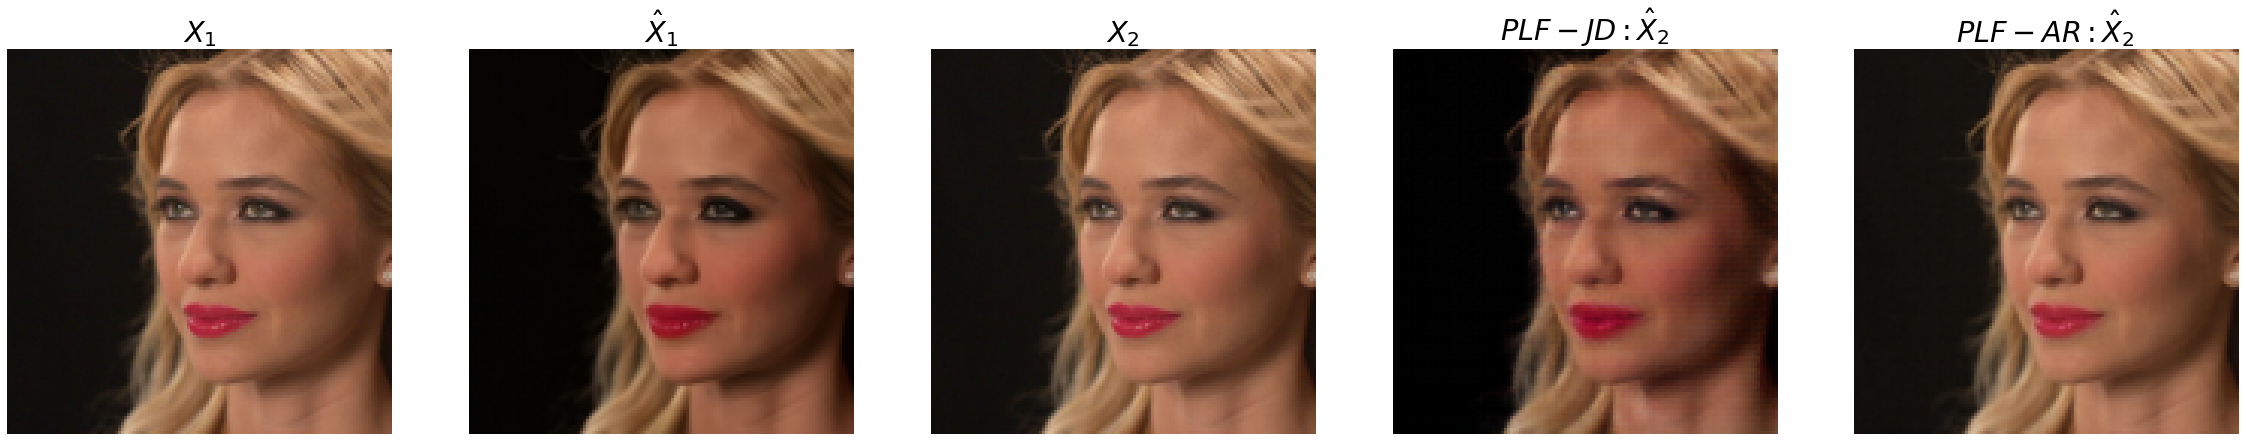

In [27]:
idx = 21
plt.figure(figsize = (40,30))
plt.rcParams.update({'font.size': 24})

x1_img = (hwc_tonp((resize(x1,(128,128))+1)*0.5))[idx]
x2_img = (hwc_tonp((resize(x2,(128,128))+1)*0.5))[idx]
x3_img = (hwc_tonp((resize(x3,(128,128))+1)*0.5))[idx]
x1_hat_img = (hwc_tonp((resize(x1_hat,(128,128))+1)*0.5))[idx]
x2_hat_JD_img = (hwc_tonp((resize(x2_hat_JD,(128,128))+1)*0.5))[idx]
x2_hat_AR_img = (hwc_tonp((resize(x2_hat_AR,(128,128))+1)*0.5))[idx]
x3_hat_JD_img = (hwc_tonp((resize(x3_hat_JD,(128,128))+1)*0.5))[idx]
x3_hat_AR_img = (hwc_tonp((resize(x3_hat_AR,(128,128))+1)*0.5))[idx]

plt.subplot(1,5,1)
plt.imshow(x1_img)
plt.title('$X_1$')
plt.axis('off')

plt.subplot(1,5,2)
plt.title('$\hat{X}_1$')
plt.imshow(x1_hat_img)
plt.axis('off')

plt.subplot(1,5,3)
plt.title('$X_2$')
plt.imshow(x2_img)
plt.axis('off')

plt.subplot(1,5,4)
plt.title('$PLF-JD: \hat{X}_2$')
plt.imshow(x2_hat_JD_img)
plt.axis('off')

plt.subplot(1,5,5)
plt.title('$PLF-AR: \hat{X}_2$ ')
plt.imshow(x2_hat_AR_img)
plt.axis('off')

letter = 'k'
os.makedirs(f'./reconstructions/R1-eps(uvg)/{letter}/', exist_ok=True)
plt.imsave(f"./reconstructions/R1-eps(uvg)/{letter}/x1.png", x1_img)
plt.imsave(f"./reconstructions/R1-eps(uvg)/{letter}/x2.png", x2_img)
plt.imsave(f"./reconstructions/R1-eps(uvg)/{letter}/x3.png", x3_img)
plt.imsave(f"./reconstructions/R1-eps(uvg)/{letter}/x1_hat.png", x1_hat_img)
plt.imsave(f"./reconstructions/R1-eps(uvg)/{letter}/x2_hat_JD.png", x2_hat_JD_img)
plt.imsave(f"./reconstructions/R1-eps(uvg)/{letter}/x2_hat_AR.png", x2_hat_AR_img)
plt.imsave(f"./reconstructions/R1-eps(uvg)/{letter}/x3_hat_JD.png", x3_hat_JD_img)
plt.imsave(f"./reconstructions/R1-eps(uvg)/{letter}/x3_hat_AR.png", x3_hat_AR_img)